# Analyze archive

This notebook contains the code to analyse content of the PubMedCentral Author Manuscript Collection. \
See: https://www.ncbi.nlm.nih.gov/pmc/about/mscollection/

Files can be downloaded here: https://ftp.ncbi.nlm.nih.gov/pub/pmc/manuscript/ \
**Please ensure** that files are downloaded into `pmc_dataset` folder to proceed.

In [1]:
dict_articles = {}

with open("pmc_dataset/filelist.txt", 'r') as f:
    for line in f:
        filename, pmcid, pmid, mid = line.split()
        if filename == 'File':
            continue
        dict_articles[pmid] = filename

In [2]:
len(dict_articles)

649546

In [3]:
list(dict_articles.values())[:10]

['PMC0012XXXXX/PMC1249490.xml',
 'PMC0012XXXXX/PMC1249491.xml',
 'PMC0012XXXXX/PMC1249508.xml',
 'PMC0012XXXXX/PMC1266050.xml',
 'PMC0012XXXXX/PMC1266051.xml',
 'PMC0012XXXXX/PMC1274277.xml',
 'PMC0012XXXXX/PMC1282457.xml',
 'PMC0012XXXXX/PMC1283128.xml',
 'PMC0012XXXXX/PMC1283142.xml',
 'PMC0013XXXXX/PMC1314973.xml']

In [14]:
!pip install lxml

     |████████████████████████████████| 5.7MB 738kB/s eta 0:00:01


In [27]:
from collections import Counter

def count_tags(node):
    stat = Counter()
    def dfs(root):
        stat[root.tag] += 1
        for child in root.getchildren():
            dfs(child)
    dfs(node)
    return stat

In [6]:
from lxml import etree

tree = etree.parse("pmc_dataset/" + list(dict_articles.values())[0])

In [7]:
dir(tree.getroot())

['__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_init',
 'addnext',
 'addprevious',
 'append',
 'attrib',
 'base',
 'clear',
 'cssselect',
 'extend',
 'find',
 'findall',
 'findtext',
 'get',
 'getchildren',
 'getiterator',
 'getnext',
 'getparent',
 'getprevious',
 'getroottree',
 'index',
 'insert',
 'items',
 'iter',
 'iterancestors',
 'iterchildren',
 'iterdescendants',
 'iterfind',
 'itersiblings',
 'itertext',
 'keys',
 'makeelement',
 'nsmap',
 'prefix',
 'remove',
 'replace',
 'set',
 'sourceline',
 'tag',
 'tail',
 'text',
 'values',
 'xpath']

In [37]:
tree.getroot().find("front").find("article-meta").find("title-group").find("article-title").text

'Pharmacogenetics in model systems: Defining a common mechanism of action for mood stabilisers'

In [54]:
def get_title(tree):
    return etree.tostring(tree.getroot().find("front").find("article-meta").find("title-group").find("article-title"))

In [59]:
review_filenames = set()
for i, filename in enumerate(dict_articles.values()):
    if i % 1000 == 0:
        print(f"\r{i}", end="")
    tree = etree.parse("pmc_dataset/" + filename)
    title = str(get_title(tree))
    if not title:
        print(f"\r{filename}")
    if "review" in title.lower():
        review_filenames.add(filename)

649000

In [60]:
print(len(review_filenames))

7270


In [28]:
stats = count_tags(tree.getroot())

In [29]:
stats

Counter({'article': 1,
         <cyfunction ProcessingInstruction at 0x7f6941982dd0>: 1,
         'front': 1,
         'journal-meta': 1,
         'journal-id': 4,
         'journal-title-group': 1,
         'journal-title': 1,
         'issn': 2,
         'article-meta': 1,
         'article-id': 4,
         'article-categories': 1,
         'subj-group': 1,
         'subject': 1,
         'title-group': 1,
         'article-title': 72,
         'contrib-group': 1,
         'contrib': 1,
         'name': 309,
         'surname': 309,
         'given-names': 309,
         'xref': 115,
         'aff': 1,
         'author-notes': 1,
         'corresp': 1,
         'italic': 70,
         'email': 1,
         'pub-date': 3,
         'day': 2,
         'month': 3,
         'year': 74,
         'volume': 72,
         'issue': 1,
         'fpage': 72,
         'lpage': 72,
         'permissions': 1,
         'license': 1,
         'license-p': 1,
         'abstract': 1,
         'p': 35,
    

In [61]:
tag_stat = {}
tag_stat['review'] = Counter()
tag_stat['ordinary'] = Counter()
for i, filename in enumerate(dict_articles.values()):
    if i % 1000 == 0:
        print(f"\r{i}", end="")
    tree = etree.parse("pmc_dataset/" + filename)
    cur_stat = count_tags(tree.getroot())
    if filename in review_filenames:
        tag_stat['review'] += cur_stat
    else:
        tag_stat['ordinary'] += cur_stat

649000

In [67]:
for s, cnt in zip(['ordinary', 'review'], [649546 - 7270, 7270]):
    with open(f'{s}_tag_stat.txt', 'w') as f:
        srt = sorted(tag_stat[s].items(), key=lambda x: x[1])
        srt = list(map(lambda x: (x[0], x[1]/cnt), srt))
        print(f'Number: {cnt}', file=f)
        for val, count in srt:
            print(f'{val} {count}', file=f)

In [68]:
def tag_depth(node):
    def dfs(root):
        d = 1
        for child in root.getchildren():
            d = max(d, dfs(child) + 1)
        return d
    return dfs(node)

In [70]:
d_stat = {}
d_stat['review'] = {}
d_stat['ordinary'] = {}
for i, filename in enumerate(dict_articles.values()):
    if i % 1000 == 0:
        print(f"\r{i}", end="")
    tree = etree.parse("pmc_dataset/" + filename)
    cur_stat = tag_depth(tree.getroot())
    if filename in review_filenames:
        d_stat['review'][filename] = cur_stat
    else:
        d_stat['ordinary'][filename] = cur_stat

649000

In [72]:
print(list(d_stat['review'].items())[:10])

[('PMC0014XXXXX/PMC1475922.xml', 8), ('PMC0015XXXXX/PMC1513666.xml', 14), ('PMC0019XXXXX/PMC1948029.xml', 10), ('PMC0020XXXXX/PMC2020839.xml', 8), ('PMC0020XXXXX/PMC2080777.xml', 10), ('PMC0022XXXXX/PMC2230686.xml', 8), ('PMC0022XXXXX/PMC2231514.xml', 8), ('PMC0022XXXXX/PMC2231609.xml', 8), ('PMC0022XXXXX/PMC2231841.xml', 9), ('PMC0025XXXXX/PMC2517215.xml', 8)]


In [74]:
for s in ['ordinary', 'review']:
    with open(f'{s}_tag_depth.txt', 'w') as f:
        srt = sorted(d_stat[s].items(), key=lambda x: x[1])
        for val, count in srt:
            print(f'{val} {count}', file=f)

In [76]:
!pip install matplotlib

     |████████████████████████████████| 13.1MB 513kB/s eta 0:00:01
     |████████████████████████████████| 71kB 2.4MB/s  eta 0:00:01
     |████████████████████████████████| 92kB 1.6MB/s  eta 0:00:01
     |████████████████████████████████| 20.1MB 365kB/s  eta 0:00:01


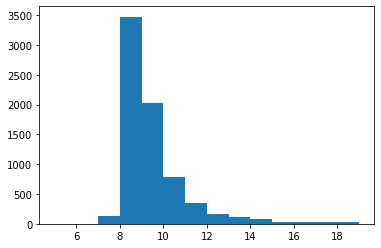

In [86]:
import matplotlib.pyplot as plt

plt.hist(d_stat['review'].values(), bins=range(5, 20))
plt.show()

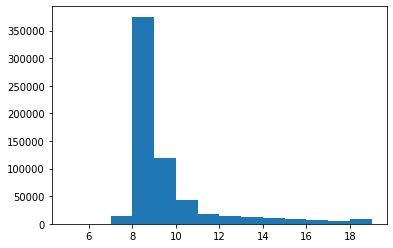

In [85]:
plt.hist(d_stat['ordinary'].values(), bins=range(5, 20))
plt.show()

In [6]:
tree = etree.parse("pmc_dataset/" + list(dict_articles.values())[0])

In [30]:
from collections import Counter

def get_paragraph_info(root):
    num = 0
    sum_pos = -1
    disc_pos = -1
    lens = Counter()
    for ch in root.find('body').getchildren():
        if ch.tag == 'sec':
            num += 1
            try:
                lens[num] = len(etree.tostring(ch))
            except Exception:
                lens[num] = 0
                print("\n!")
            str_title = str(etree.tostring(ch.find('title'))).lower()
            if 'summary' in str_title:
                sum_pos = num
            if 'discussion' in str_title:
                disc_pos = num
    return num, sum_pos, disc_pos, lens  

In [4]:
review_filenames = set()

with open('review_tag_depth.txt', 'r') as f:
    for line in f:
        filename, _ = line.split()
        review_filenames.add(filename)

In [7]:
with open("dataset_with_refs/review_files.csv", 'w') as f:
    for filename in review_filenames:
        for pmid, fname in dict_articles.items():
            if fname == filename:
                print(f'{pmid}\t{fname}', file=f)
                break

In [32]:
para_stats = {}
para_stats['review'] = {}
para_stats['ordinary'] = {}


for i, filename in enumerate(dict_articles.values()):
    if i % 1000 == 0:
        print(f"\r{i}", end="")
    tree = etree.parse("pmc_dataset/" + filename)
    try:
        cur_stat = get_paragraph_info(tree.getroot())
    except Exception:
        print(f"\n{filename}")
        continue
    if filename in review_filenames:
        para_stats['review'][filename] = cur_stat
    else:
        para_stats['ordinary'][filename] = cur_stat

12000
!
22000
!
36000
PMC0027XXXXX/PMC2772122.xml
49000
PMC0028XXXXX/PMC2826148.xml
56000
!
81000
PMC0029XXXXX/PMC2939973.xml
89000
PMC0029XXXXX/PMC2977080.xml
97000
PMC0030XXXXX/PMC3027064.xml
151000
PMC0032XXXXX/PMC3272455.xml
185000
!
218000
PMC0036XXXXX/PMC3640583.xml
243000
PMC0037XXXXX/PMC3752889.xml
252000
PMC0037XXXXX/PMC3795958.xml
268000
PMC0038XXXXX/PMC3880250.xml
272000
!
280000
!
295000
PMC0040XXXXX/PMC4017663.xml

PMC0040XXXXX/PMC4017670.xml
321000
PMC0041XXXXX/PMC4141783.xml
335000
PMC0042XXXXX/PMC4215702.xml
341000
!
343000
PMC0042XXXXX/PMC4260990.xml
355000
PMC0043XXXXX/PMC4324758.xml
376000
PMC0044XXXXX/PMC4435688.xml
393000
PMC0045XXXXX/PMC4526402.xml
399000
PMC0045XXXXX/PMC4564300.xml
403000
PMC0045XXXXX/PMC4589162.xml
408000
PMC0046XXXXX/PMC4630023.xml
412000
PMC0046XXXXX/PMC4657549.xml
414000
!
416000
PMC0046XXXXX/PMC4681672.xml
418000
PMC0046XXXXX/PMC4696020.xml
422000
PMC0047XXXXX/PMC4715672.xml
425000
PMC0047XXXXX/PMC4740202.xml
432000
PMC0047XXXXX/PMC4779726.x

In [34]:
list(para_stats['review'].items())[:10]

[('PMC0014XXXXX/PMC1475922.xml',
  (5, -1, 4, Counter({1: 6617, 2: 1691, 3: 4246, 4: 4367, 5: 2979}))),
 ('PMC0015XXXXX/PMC1513666.xml',
  (5, 5, -1, Counter({1: 3276, 2: 808, 3: 15938, 4: 8318, 5: 836}))),
 ('PMC0019XXXXX/PMC1948029.xml',
  (4, -1, 4, Counter({1: 5388, 2: 1243, 3: 14885, 4: 8199}))),
 ('PMC0020XXXXX/PMC2020839.xml',
  (6,
   -1,
   -1,
   Counter({1: 7656, 2: 698, 3: 6026, 4: 16800, 5: 6978, 6: 4003}))),
 ('PMC0020XXXXX/PMC2080777.xml',
  (6,
   -1,
   5,
   Counter({1: 1223, 2: 2271, 3: 14611, 4: 6086, 5: 12156, 6: 703}))),
 ('PMC0022XXXXX/PMC2230686.xml',
  (5, -1, 4, Counter({1: 5607, 2: 9020, 3: 20241, 4: 9453, 5: 1444}))),
 ('PMC0022XXXXX/PMC2231514.xml',
  (3, -1, -1, Counter({1: 23725, 2: 19212, 3: 8193}))),
 ('PMC0022XXXXX/PMC2231609.xml',
  (5, 5, -1, Counter({1: 7194, 2: 20756, 3: 16506, 4: 7558, 5: 891}))),
 ('PMC0022XXXXX/PMC2231841.xml',
  (7,
   -1,
   7,
   Counter({1: 732, 2: 4316, 3: 1601, 4: 2164, 5: 11186, 6: 6315, 7: 7018}))),
 ('PMC0025XXXXX/PMC25

[5, 5, 4, 6, 6, 5, 3, 5, 7, 4]


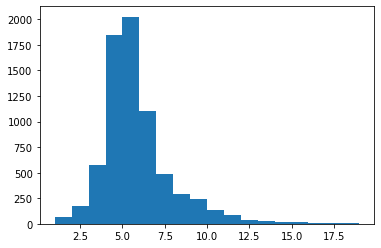

In [37]:
import matplotlib.pyplot as plt

para_nums = list(map(lambda x: x[1][0], para_stats['review'].items()))
print(para_nums[:10])
plt.hist(para_nums, bins=range(1, 20))
plt.show()

[8, 3, 3, 7, 4, 4, 4, 4, 6, 4]


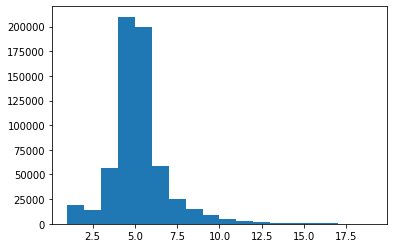

In [38]:
para_nums = list(map(lambda x: x[1][0], para_stats['ordinary'].items()))
print(para_nums[:10])
plt.hist(para_nums, bins=range(1, 20))
plt.show()

[-1, 5, -1, -1, -1, -1, -1, 5, -1, -1]


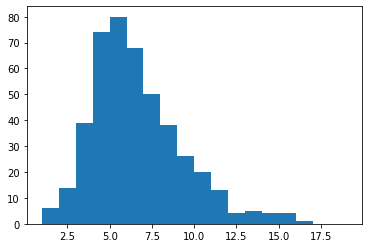

In [41]:
sum_stat = list(map(lambda x: x[1][1], para_stats['review'].items()))
print(sum_stat[:10])
plt.hist(sum_stat, bins=range(1, 20))
plt.show()

[8, -1, -1, -1, -1, -1, -1, -1, -1, -1]


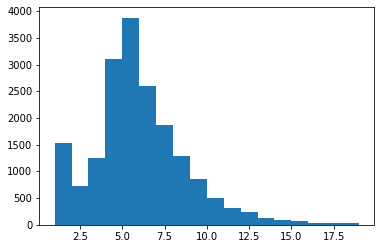

In [44]:
sum_stat = list(map(lambda x: x[1][1], para_stats['ordinary'].items()))
print(sum_stat[:10])
plt.hist(sum_stat, bins=range(1, 20))
plt.show()

[4, -1, 4, -1, 5, 4, -1, -1, 7, 4]


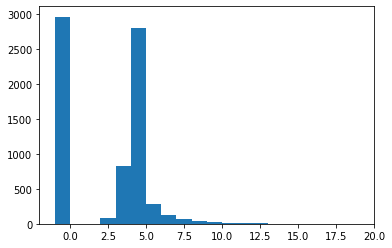

In [46]:
sum_stat = list(map(lambda x: x[1][2], para_stats['review'].items()))
print(sum_stat[:10])
plt.hist(sum_stat, bins=range(-1, 20))
plt.show()

[-1, 3, 3, 3, 4, 4, 4, 4, -1, 4]


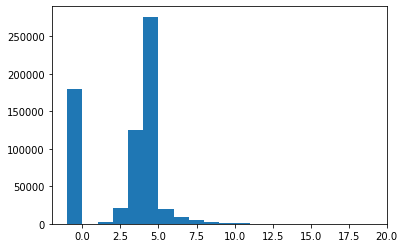

In [48]:
sum_stat = list(map(lambda x: x[1][2], para_stats['ordinary'].items()))
print(sum_stat[:10])
plt.hist(sum_stat, bins=range(-1, 20))
plt.show()

In [51]:
import functools

len_stat = functools.reduce(lambda x, y: x + y, map(lambda x: x[1][3], para_stats['review'].items()))

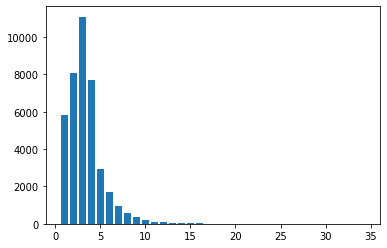

In [56]:
plt.bar(len_stat.keys(), list(map(lambda x: x / len(para_stats['review'].items()), len_stat.values())))
plt.show()

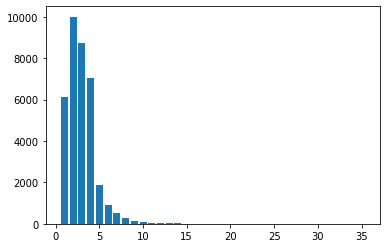

In [60]:
len_stat = functools.reduce(lambda x, y: x + y, map(lambda x: x[1][3], para_stats['ordinary'].items()))
plt.bar(list(map(lambda x: min(35, x), len_stat.keys())), list(map(lambda x: x / len(para_stats['ordinary'].items()), len_stat.values())))
plt.show()

In [62]:
xml = '<tag>Some <a>example</a> text</tag>'
tree = etree.fromstring(xml)
print(''.join(tree.itertext()))

Some example text


In [63]:
list(filter(lambda x: x[1][0] == 1, para_stats['ordinary'].items()))[:10]

[('PMC0013XXXXX/PMC1351280.xml', (1, -1, -1, Counter({1: 4903}))),
 ('PMC0014XXXXX/PMC1410731.xml', (1, -1, -1, Counter({1: 2751}))),
 ('PMC0014XXXXX/PMC1482253.xml', (1, -1, -1, Counter({1: 40122}))),
 ('PMC0016XXXXX/PMC1609190.xml', (1, -1, -1, Counter({1: 812}))),
 ('PMC0016XXXXX/PMC1613257.xml', (1, -1, -1, Counter({1: 38755}))),
 ('PMC0017XXXXX/PMC1780257.xml', (1, -1, -1, Counter({1: 5789}))),
 ('PMC0018XXXXX/PMC1800886.xml', (1, -1, -1, Counter({1: 491}))),
 ('PMC0018XXXXX/PMC1817751.xml', (1, -1, -1, Counter({1: 30788}))),
 ('PMC0018XXXXX/PMC1828614.xml', (1, -1, -1, Counter({1: 1560}))),
 ('PMC0018XXXXX/PMC1855444.xml', (1, -1, -1, Counter({1: 3326})))]

In [7]:
from collections import Counter

def get_conc_info(root):
    conc_pos = -1
    num = 0
    for ch in root.find('body').getchildren():
        if ch.tag == 'sec':
            num += 1
            str_title = str(etree.tostring(ch.find('title'))).lower()
            if 'conclusion' in str_title:
                conc_pos = num
    return conc_pos 

In [8]:
conc_stats = {}
conc_stats['review'] = {}
conc_stats['ordinary'] = {}


for i, filename in enumerate(dict_articles.values()):
    if i % 1000 == 0:
        print(f"\r{i}", end="")
    tree = etree.parse("pmc_dataset/" + filename)
    try:
        cur_stat = get_conc_info(tree.getroot())
    except Exception:
        print(f"\n{filename}")
        continue
    if filename in review_filenames:
        conc_stats['review'][filename] = cur_stat
    else:
        conc_stats['ordinary'][filename] = cur_stat

36000
PMC0027XXXXX/PMC2772122.xml
49000
PMC0028XXXXX/PMC2826148.xml
81000
PMC0029XXXXX/PMC2939973.xml
89000
PMC0029XXXXX/PMC2977080.xml
97000
PMC0030XXXXX/PMC3027064.xml
151000
PMC0032XXXXX/PMC3272455.xml
218000
PMC0036XXXXX/PMC3640583.xml
243000
PMC0037XXXXX/PMC3752889.xml
252000
PMC0037XXXXX/PMC3795958.xml
268000
PMC0038XXXXX/PMC3880250.xml
295000
PMC0040XXXXX/PMC4017663.xml

PMC0040XXXXX/PMC4017670.xml
321000
PMC0041XXXXX/PMC4141783.xml
335000
PMC0042XXXXX/PMC4215702.xml
343000
PMC0042XXXXX/PMC4260990.xml
355000
PMC0043XXXXX/PMC4324758.xml
376000
PMC0044XXXXX/PMC4435688.xml
393000
PMC0045XXXXX/PMC4526402.xml
399000
PMC0045XXXXX/PMC4564300.xml
403000
PMC0045XXXXX/PMC4589162.xml
408000
PMC0046XXXXX/PMC4630023.xml
412000
PMC0046XXXXX/PMC4657549.xml
416000
PMC0046XXXXX/PMC4681672.xml
418000
PMC0046XXXXX/PMC4696020.xml
422000
PMC0047XXXXX/PMC4715672.xml
425000
PMC0047XXXXX/PMC4740202.xml
432000
PMC0047XXXXX/PMC4779726.xml

PMC0047XXXXX/PMC4780436.xml
435000
PMC0048XXXXX/PMC4803281.xml

P

KeyboardInterrupt: 

[5, -1, -1, 6, 6, 5, -1, 5, -1, -1]


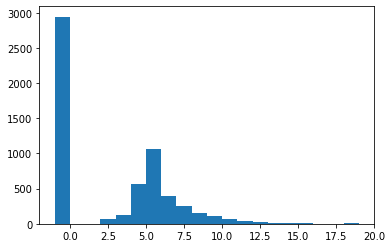

In [11]:
import matplotlib.pyplot as plt

conc_stat = list(map(lambda x: x[1], conc_stats['review'].items()))
print(conc_stat[:10])
plt.hist(conc_stat, bins=range(-1, 20))
plt.show()

[-1, -1, -1, -1, -1, -1, -1, -1, 6, -1]


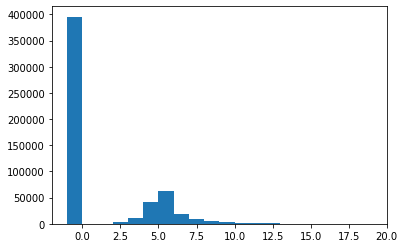

In [12]:
conc_stat = list(map(lambda x: x[1], conc_stats['ordinary'].items()))
print(conc_stat[:10])
plt.hist(conc_stat, bins=range(-1, 20))
plt.show()

In [12]:
def get_text(root):
    text = root.find('body').itertext()
    return ''.join(text)

In [13]:
tree = etree.parse("pmc_dataset/PMC0013XXXXX/PMC1351280.xml")

In [14]:
get_text(tree.getroot())

'\n    Currently little is known about the site and mechanisms of eye-specific suppression during rivalry. The earliest stage after the retina where differential eye-specific modulation could occur is the LGN, which contains monocular neurons segregated into eye-specific layers7. Although excited only by monocular stimulation, neurons in primate LGN can nevertheless show robust inhibitory binocular interactions8. However, fluctuations in activity associated with changing perception during binocular rivalry have proven inconsistent in cat9,10 and apparently absent in monkey11. There have been no reported investigations of binocular rivalry in the human LGN. Common to all these previous studies is the absence of behavioural measures of perceptual dominance (either because the animals were anaesthetised, or because they were not required to report their perceptual experience). The lack of behavioural measurements for classifying neuronal responses will have significantly lowered the power

In [16]:
!pip install nltk

     |████████████████████████████████| 1.5MB 722kB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.4.5-cp37-none-any.whl size=1449908 sha256=67c500246ca756bfec25abe16dcc91620e48b5602b63f9c17599968193cc7544
  Stored in directory: /home/student/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk


In [30]:
nltk.download('webtext')
nltk.download('punkt')

[nltk_data] Downloading package webtext to /home/student/nltk_data...
[nltk_data]   Package webtext is already up-to-date!
[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
import nltk

text = nltk.tokenize.sent_tokenize(get_text(tree.getroot()))

In [32]:
text

['\n    Currently little is known about the site and mechanisms of eye-specific suppression during rivalry.',
 'The earliest stage after the retina where differential eye-specific modulation could occur is the LGN, which contains monocular neurons segregated into eye-specific layers7.',
 'Although excited only by monocular stimulation, neurons in primate LGN can nevertheless show robust inhibitory binocular interactions8.',
 'However, fluctuations in activity associated with changing perception during binocular rivalry have proven inconsistent in cat9,10 and apparently absent in monkey11.',
 'There have been no reported investigations of binocular rivalry in the human LGN.',
 'Common to all these previous studies is the absence of behavioural measures of perceptual dominance (either because the animals were anaesthetised, or because they were not required to report their perceptual experience).',
 'The lack of behavioural measurements for classifying neuronal responses will have signif